In [44]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import os
import pandas as pd
import torch
from backbone import backbone
from CSP import ConvBlock
import torch.nn as nn

import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from yolo2 import Yolo
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
from utils import cells_to_bboxes, non_max_suppression, use_gpu_if_possible
from torchvision import transforms
IMAGE_SIZE = 416
BATCH_SIZE = 1
NUM_WORKERS = 4
DATASET = 'dataset'
IMG_DIR = DATASET + "/images/"
LABEL_DIR = DATASET + "/labels/"


In [45]:
class Yolo_Block(nn.Module):
    
    def __init__(self,in_channels,B,num_classes):
        super().__init__()
        self.back = backbone(in_channels)
        self.conv1 = ConvBlock(512,512,3,1)
        self.conv2 = ConvBlock(512,256,3,1)
        self.conv3 = nn.Conv2d(512,128,1,1)
        self.upsample = nn.ConvTranspose2d(128,256,2,2)
        self.conv4 = nn.Conv2d(256,255,1,1)
        self.conv5 = nn.Conv2d(512,255,1,1)
        self.head = nn.Conv2d(255,B*(5+num_classes),1,1)
        self.B = B
        #self.generate()

    def forward(self,x):
        out1 , out2 = self.back(x)
        out2 = self.conv1(out2)
        feat2 = out2
        out2 = self.conv3(out2)
        feat1 = torch.cat([out1,self.upsample(out2)],dim=1)
        feat2 = self.conv1(feat2)
        feat1 = self.conv2(feat1)
        feat1 = self.conv4(feat1)
        feat2 = self.conv5(feat2)
        return self.head(feat2).reshape(feat2.shape[0], self.B, 2 + 5, feat2.shape[2], feat2.shape[3]).permute(0, 1, 3, 4, 2),self.head(feat1).reshape(feat1.shape[0], self.B, 2 + 5, feat1.shape[2], feat1.shape[3]).permute(0, 1, 3, 4, 2)

In [52]:
def imread(path, **kwargs):
    img = cv2.imread(path, **kwargs)
    if img is None:
        raise RuntimeError(f"Nonexisting image at path {path}")
    return img

image = imread("dataset/images/1_Handshaking_Handshaking_1_65.jpg")
frame = cv.resize(or_image, (416, 416))
frame_tensor = transforms.ToTensor()(frame).unsqueeze_(0)


#bboxes = np.roll(np.loadtxt(fname="dataset/labels/1_Handshaking_Handshaking_1_65.txt", delimiter=" ", ndmin=2), 4, axis=1).tolist()
net=Yolo_Block(3,3,2).eval()
        
model_dict=torch.load("downblur.pt", map_location = use_gpu_if_possible())
net.load_state_dict(model_dict)
out = net(frame_tensor)

boxes = []
ANCHORS =  [[(0.275 ,   0.320312), (0.068   , 0.113281), (0.017  ,  0.03   )], 
           [(0.03  ,   0.056   ), (0.01  ,   0.018   ), (0.006 ,   0.01    )]]  
S = [13,26]   
scaled_anchors = torch.tensor(ANCHORS) / (
    1 / torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2))

for i in range(2):
    anchor = scaled_anchors[i]
    #print(anchor.shape)
    #print(out[i].shape)
    boxes += cells_to_bboxes(out[i], S=out[i].shape[2], anchors = anchor)[0]
    
boxes = non_max_suppression(boxes, iou_threshold= 0.1, threshold=0.65, box_format = "midpoint")

for box in boxes:
    if box[0] == 0: # mask
            color = (0,250,154)
            label = 'mask'
    else: # no mask
            color = (255, 0, 0)
            label = 'no mask'
    height, width ,_ = image.shape
    p = box[1]
    box = box[2:]
    p0 = (int((box[0] - box[2]/2)*height) ,int((box[1] - box[3]/2)*width))
    p1 = (int((box[0] + box[2]/2)*height) ,int((box[1] + box[3]/2)*width))
    image = cv.rectangle(image, p0, p1, color, thickness=2)
    cv.putText(image, label + "{:.2f}".format(p*100) + '%', (int((box[0] - box[2]/2)*height), int((box[1] - box[3]/2)*width)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
image = cv.cvtColor(image, cv2.COLOR_BGR2RGB)
cv.imshow('detect',image)

#plt.axis('off')
#plt.show()
#cv.imwrite('original.png',image)


In [12]:
bboxes

[[0.187, 0.354, 0.08, 0.183, 1.0],
 [0.383, 0.387, 0.082, 0.175, 1.0],
 [0.672, 0.504, 0.074, 0.143, 1.0],
 [0.806, 0.286, 0.076, 0.175, 1.0]]

In [9]:
transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=IMAGE_SIZE),
        A.PadIfNeeded(
            min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=0
        ),
        #A.OneOf(
        #    [
        #        A.ShiftScaleRotate( # Randomly apply affine transforms: translate, scale and rotate the input.
        #            rotate_limit=20, p=0.5, border_mode=1
        #        ),
        #        A.Affine(shear=15, p=0.5),
        #    ],
        #    p=1.0,
        #),
        #A.HorizontalFlip(p=1),
        #A.Normalize(mean=[0., 0., 0.], std=[1., 1., 1.], max_pixel_value=255,),
        #A.Downscale (scale_min=0.25, scale_max=0.25, interpolation=0, always_apply=True, p=1),
        #A.MotionBlur(p=1),
        ToTensorV2()
       
    ]
    #bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[]),
    
    )

In [15]:


augmentations = transforms(image=image, bboxes=bboxes)
#image2 = augmentations["image"]
#bboxes = augmentations["bboxes"]

True

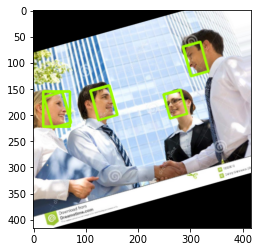

In [17]:
box=bboxes[0]

height, width , _= image2.shape
p0 = (int((box[0] - box[2]/2)*height) ,int((box[1] - box[3]/2)*width))
p1 = (int((box[0] + box[2]/2)*height) ,int((box[1] + box[3]/2)*width))
image=cv2.rectangle(image2, p0, p1, color=(0,250,154), thickness=4)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
cv2.imwrite('affine.png',image)